# Import dependencies

In [1]:
#!pip install category_encoders
#!pip install gspread
#!pip install oauth2client

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Importing the dataset

In [4]:
#We used a google sheet as a database table in this project to store the data. 
#We pull the data in through the google API and setup a project in google cloud to manage this setup.
# Define the scope
scope = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']

# Add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('gs_credentials.json', scope)

# Authorize the clientsheet 
client = gspread.authorize(creds)

# Open the sheet
sheet = client.open("GWU_data_sheet").sheet1

# Get all records
records = sheet.get_all_records()

# Convert to DataFrame (optional)
df = pd.DataFrame.from_records(records)

In [5]:
#Printing out the head to get a quick overview of the dataframe.
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,2698,CA-2014-145317,2020-03-16 00:00:00,2020-03-21 00:00:00,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,...,32216,South,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
1,6827,CA-2016-118689,2022-10-01 00:00:00,2022-10-08 00:00:00,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,47905,Central,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760
2,8154,CA-2017-140151,2023-03-22 00:00:00,2023-03-24 00:00:00,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,98115,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808
3,2624,CA-2017-127180,2023-10-21 00:00:00,2023-10-23 00:00:00,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,...,10024,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888
4,4191,CA-2017-166709,2023-11-16 00:00:00,2023-11-21 00:00:00,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,19711,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856


In [6]:
#We set the order date as a date column. This was not done automatically due to the API call fromt he google sheet.
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [7]:
#We conduct data manupulations on our dataset.
df['per_unit_price'] = df['Sales'] / df['Quantity']
df['per_unit_profit'] = df['Profit'] / df['Quantity']
df['Profit_margin'] = df['Profit'] / df['Sales']
#Here the original price is calculated. This is the price before any discounts were given.
df['Original_Price'] = df['Sales'] / (1 - df['Discount'])
df['original_per_unit_price'] = df['Original_Price'] / df['Quantity']

In [8]:
#We extract the month and year into seerate columns as we want to predict per year and month.
df['order_month'] = df['Order Date'].dt.month
df['order_year'] = df['Order Date'].dt.year

In [9]:
#We create a pandas profile report. This to get ahigh level overview of the dataset and identify any potentional issues.
#df.profile_report()

In [10]:
#We wrote this function to remove the outliers from the dataset. 
#Currently we only use this for the sales values column.
#We generate a boxplot to show the spread of the values in the column and identify the quartiles and outliers using pandas.
def analyze_and_filter_column(df, column_name):
    # Convert column to list and plot boxplot
    column_data = df[column_name].tolist()
    fig, ax = plt.subplots()
    ax.set_title(f'{column_name} Boxplot')
    ax.set_ylabel(column_name)
    ax.boxplot(column_data)
    plt.show()

    # Calculate quartiles and IQR
    quartiles = df[column_name].quantile([.25, .5, .75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq

    # Print quartile information
    print(f"The lower quartile of {column_name} is: {lowerq}")
    print(f"The upper quartile of {column_name} is: {upperq}")
    print(f"The interquartile range of {column_name} is: {iqr}")
    print(f"The median of {column_name} is: {quartiles[0.5]} ")

    # Identify potential outliers
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")

    # Filter out potential outliers
    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    df_filtered = df_filtered.copy()

    # Return the filtered and binned DataFrame
    return df_filtered

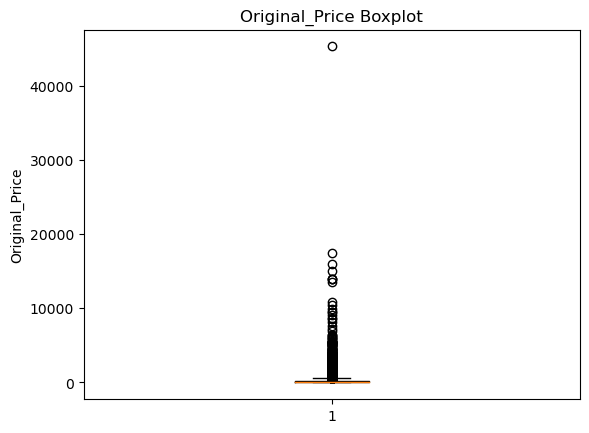

The lower quartile of Original_Price is: 21.36
The upper quartile of Original_Price is: 251.91
The interquartile range of Original_Price is: 230.55
The median of Original_Price is: 64.96 
Values below -324.46500000000003 could be outliers.
Values above 597.735 could be outliers.


In [11]:
#We call the analyze_and_filter_column function
column_name = 'Original_Price'
df = df.copy()
df = analyze_and_filter_column(df, column_name)

In [12]:
#We drop the columns we are not using in the model.
df = df.drop(columns=["Discount", 'Row ID', 'Postal Code', 'Sales', 'Profit', 'per_unit_profit', 'Profit_margin',
                      "original_per_unit_price", "Order ID",'State', "Customer ID", "City", 
                      'per_unit_price','Country',"Customer Name","Ship Date",'Ship Mode','Segment'
                     ,'Order Date','Product Name',"Product ID"])

In [13]:
#We are aggregating the dataset to make sure we go from individual sales to grouped on the Sub_Category level sales.
df = df.groupby(['order_year', 'order_month', 'Region', 'Category', 'Sub-Category'])[['Quantity', 'Original_Price']].sum().reset_index()

In [14]:
#We change the order the dataset is in to make sure during training the right priorization is maintained.
#As the first 10 colums as most important we want to make sure the sales column is at the front before the encoding.
new_order = ['Original_Price','Quantity', 'Sub-Category','order_month','Region','Category','order_year']
df = df.reindex(columns=new_order)

In [15]:
#We make a copy of the dataset for each model.
df_2 = df.copy()

In [16]:
#A quick view of the dataset
df.head()

,Original_Price,Quantity,Sub-Category,order_month,Region,Category,order_year
0,141.96,2,Bookcases,1,Central,Furniture,2020
1,479.49,9,Furnishings,1,Central,Furniture,2020
2,275.24,4,Appliances,1,Central,Office Supplies,2020
3,55.60,5,Art,1,Central,Office Supplies,2020
4,129.28,21,Binders,1,Central,Office Supplies,2020


In [17]:
#We use getdummies to convert our categorical data into a format that can be used by the machine learning algorythem.
df = pd.get_dummies(df, columns=['Region','Category', 'Sub-Category'])

In [18]:
#We get the description of the dataframe after applying the get_dummies function.
description = df.describe()
description

,Original_Price,Quantity,order_month,order_year,Region_Central,Region_East,Region_South,Region_West,Category_Furniture,Category_Office Supplies,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
count,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,...,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000,2316.000000
mean,419.493472,13.703800,6.901554,2021.565630,0.250000,0.259931,0.220207,0.269862,0.231865,0.599309,...,0.055699,0.054404,0.079447,0.063903,0.014249,0.081606,0.075130,0.072539,0.045769,0.041451
std,453.746417,14.011362,3.389321,1.124828,0.433106,0.438691,0.414476,0.443984,0.422115,0.490144,...,0.229390,0.226862,0.270494,0.244633,0.118540,0.273823,0.263657,0.259434,0.209028,0.199373
min,2.040000,1.000000,1.000000,2020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79.955000,4.000000,4.000000,2021.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,272.955000,9.000000,7.000000,2022.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,605.067500,18.000000,10.000000,2023.000000,0.250000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3055.240000,111.000000,12.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#We set the Original_Price as the target.
target = 'Original_Price'
#The other columns are used as the feature columns.
features = df.columns.drop(target)
X = df[features]
y = df[target]
#We split the data into 75% training data and 25 testing data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, test_size=0.25, random_state=42)
#Printing out the shapes of the split datasets.
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1737, 27), (579, 27), (1737,), (579,))

In [20]:
#We are using linear regression for our model
#We choose Linear Regression as it gives us a good starting point. 
#Based on the outcome we will likely choose a more advanced model for a version 2
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
#Here we calculate the 2R2 score it shows how well the observed outcomes are replicated by the model.
#With 64% the current model is not very accurate.
model.score(X_test, y_test)

0.6441849382065784

In [22]:
#pringting the head of the second dataframe for the second model
df_2

,Original_Price,Quantity,Sub-Category,order_month,Region,Category,order_year
0,141.96,2,Bookcases,1,Central,Furniture,2020
1,479.49,9,Furnishings,1,Central,Furniture,2020
2,275.24,4,Appliances,1,Central,Office Supplies,2020
3,55.60,5,Art,1,Central,Office Supplies,2020
4,129.28,21,Binders,1,Central,Office Supplies,2020
...,...,...,...,...,...,...,...
2311,1392.38,73,Paper,12,West,Office Supplies,2023
2312,2430.64,46,Storage,12,West,Office Supplies,2023
2313,73.13,8,Supplies,12,West,Office Supplies,2023
2314,1387.72,39,Accessories,12,West,Technology,2023


In [23]:
#We placed a blocker here to make sure when we adjsut variable in the first dataset 
#this so we do not accendentially adjust them for both datasets
assert df_2.shape == (2316, 7)

In [24]:
#Here we are running a analysis to determine if our model can potentionally be more accurate than a random guess
from sklearn.metrics import mean_absolute_error, r2_score
target = 'Original_Price'
y = df_2[target]
y_pred = [y.mean()] * len(y)
print('Mean Baseline:')
print('Mean Absolute Error', mean_absolute_error(y, y_pred))
print('R^2 score', r2_score(y, y_pred))
#With very even sales in our dataset the 2R2 and MAE scores are not good with 0.0 and 338
#Suggesting the prediction of our model is about the same as a random guess potentionally.

Mean Baseline:
Mean Absolute Error 338.12715571782695
R^2 score 0.0


In [25]:
# First, split the data into training and a temporary set (combining validation and test)
train, temp_df = train_test_split(df_2, test_size=0.34, random_state=42)  # 34% training, 66% temp

# Then, split the temporary set into validation and test sets
val, test = train_test_split(temp_df, test_size=0.5, random_state=42)  # Splits the temp into 50% validation, 50% test

In [26]:
train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
#Here we are defining the features
features = ['Region','Category','Sub-Category']
target = 'Original_Price'

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target] 
y_val = val[target]
y_test = test[target]

In [28]:
# category_encoders is recommended, but not required
import category_encoders as ce

In [29]:
# use fit_transform method with train set
# use transform method with val / test sets 
#The encoding allows the machine learning model to work with the categorical columns.
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [30]:
#We view the head of the x_train dataset
X_train_encoded.head()

,Region_Central,Region_South,Region_East,Region_West,Category_Technology,Category_Office Supplies,Category_Furniture,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Envelopes,...,Sub-Category_Bookcases,Sub-Category_Binders,Sub-Category_Fasteners,Sub-Category_Paper,Sub-Category_Supplies,Sub-Category_Furnishings,Sub-Category_Copiers,Sub-Category_Labels,Sub-Category_Chairs,Sub-Category_Tables
942,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
365,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1234,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1345,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1037,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Here we import and setup Sidge regression
#We choose a Ridge regression as with our poor 2R2 and MAE scores the risk of overfitting our model is very real.

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

#Here we scale our data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

ridge = RidgeCV()
ridge.fit(X_train_scaled, y_train)

RidgeCV()

In [32]:
#We pring the X_trained dataset
X_train_scaled

array([[ 1.68785855, -0.53092296, -0.58138069, ..., -0.26462806,
        -0.26320945, -0.20040802],
       [-0.59246671,  1.88351242, -0.58138069, ..., -0.26462806,
        -0.26320945, -0.20040802],
       [-0.59246671, -0.53092296,  1.72004338, ..., -0.26462806,
        -0.26320945, -0.20040802],
       ...,
       [ 1.68785855, -0.53092296, -0.58138069, ..., -0.26462806,
        -0.26320945, -0.20040802],
       [-0.59246671,  1.88351242, -0.58138069, ..., -0.26462806,
        -0.26320945, -0.20040802],
       [-0.59246671,  1.88351242, -0.58138069, ..., -0.26462806,
        -0.26320945, -0.20040802]])

In [33]:
#When we run the same analysis on the scaled datasets we can see the 2R2 and MAE score improved
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = ridge.predict(X_val_scaled)
print('Ridge Regression:')
print('Mean Absolute Error', mean_absolute_error(y_val, y_pred))
print('R^2 score', r2_score(y_val, y_pred))

Ridge Regression:
Mean Absolute Error 239.74748270726312
R^2 score 0.3123059283322809


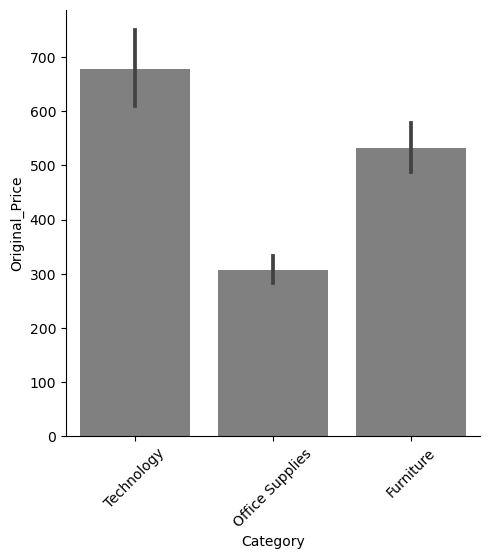

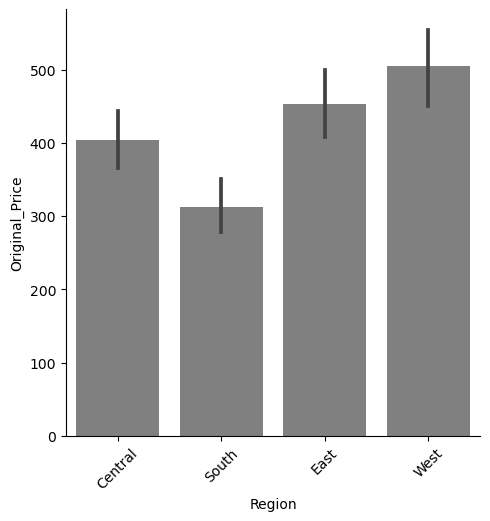

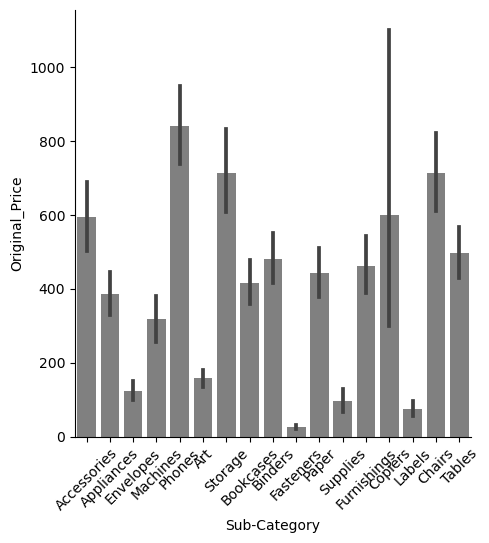

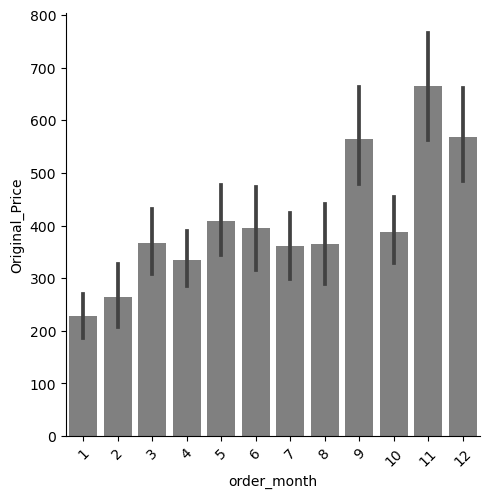

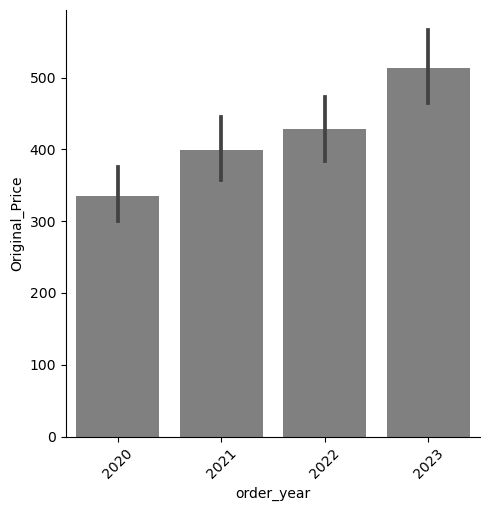

In [34]:
#These bar plots show the correlation between the Original Price and the features.

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() <= 20:
        sns.catplot(x=col, y='Original_Price', data=train, kind='bar', color='grey')
        plt.xticks(rotation=45)
        plt.show()

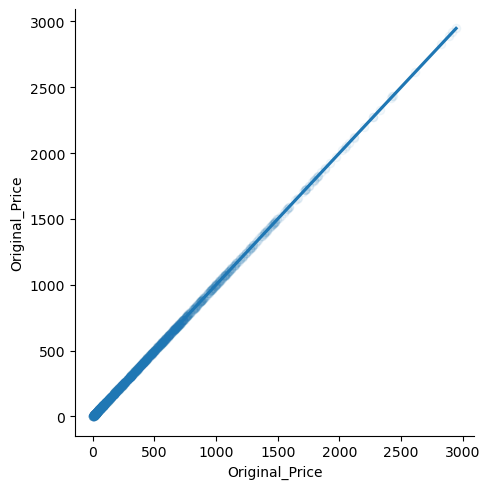

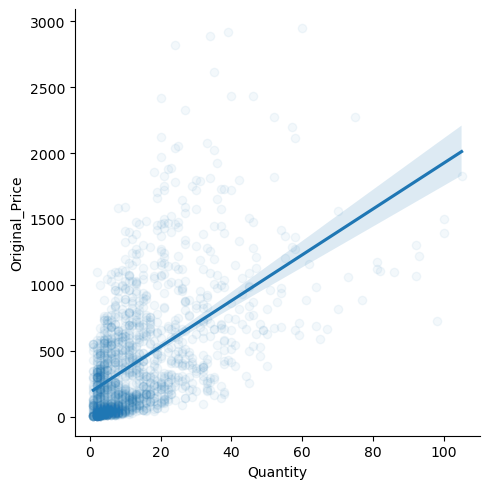

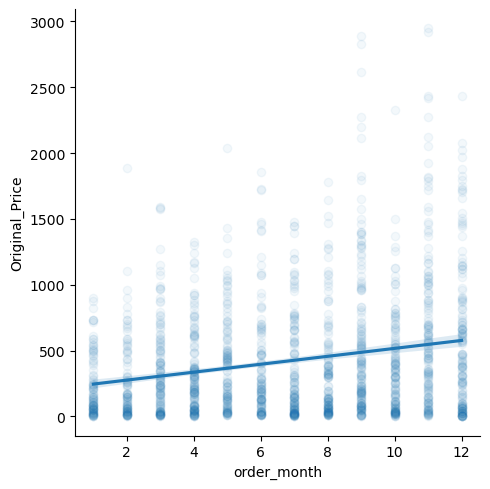

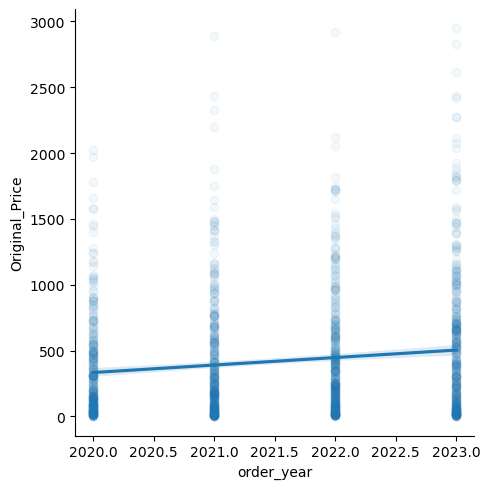

In [35]:
# Make visualizations to explore relationships between features and target
numeric = train.select_dtypes('number')
for feature in numeric:
    sns.lmplot(x=feature, y=target, data=train, scatter_kws={'alpha':0.05})
    plt.show()

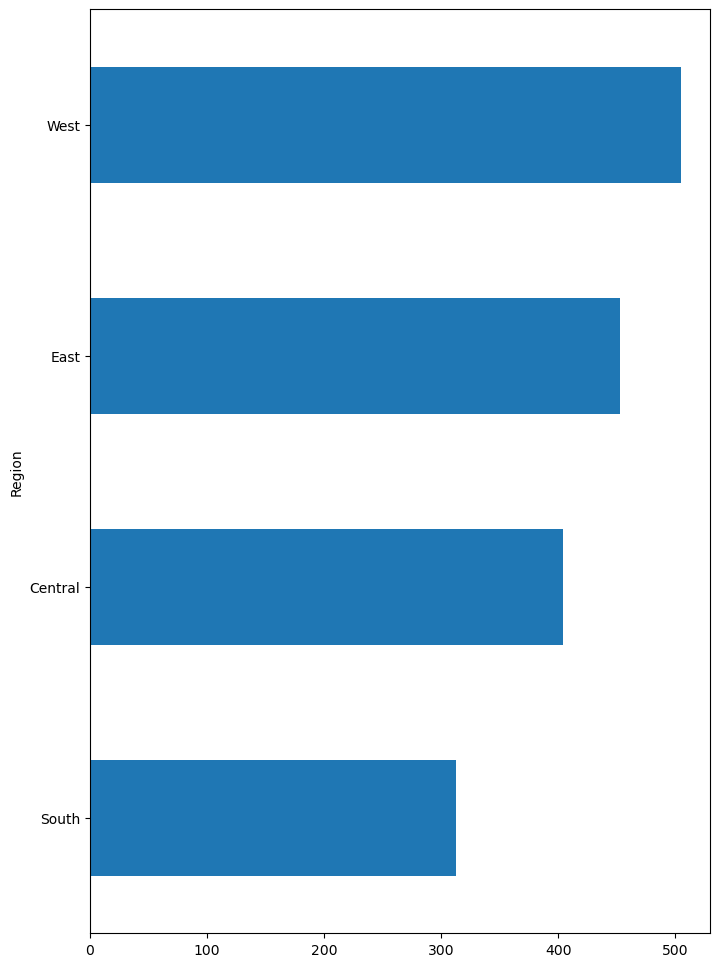

In [36]:
# Make visualizations to explore relationships between features and target
plt.figure(figsize=(8,12))
train.groupby('Region')['Original_Price'].mean().sort_values().plot.barh();

In [37]:
#Here we setup the function to assess the feature performance through key metrics like RMSE, MAE, and R^2 Score.

import numpy as np
from sklearn.metrics import mean_squared_error

def lr(train, val, features, target):
    X_train = train[features]
    y_train = train[target]
    X_val = val[features]
    y_val = val[target]

    encoder = ce.OneHotEncoder(use_cat_names=True)
    model = LinearRegression()
    X_train_encoded = encoder.fit_transform(X_train)
    X_val_encoded = encoder.transform(X_val)
    model.fit(X_train_encoded, y_train)
    y_pred_train = model.predict(X_train_encoded)
    y_pred_val = model.predict(X_val_encoded)

    print(f'Linear Regression with {len(features)} features: {features}')
    print('Train Root Mean Squared Error:', 
          np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('Validation Root Mean Square Error:', 
          np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print('Train Mean Absolute Error:', 
          mean_absolute_error(y_train, y_pred_train))
    print('Validation Mean Absolute Error:', 
          mean_absolute_error(y_val, y_pred_val))
    print('Train R^2 Score:', 
          r2_score(y_train, y_pred_train))
    print('Validation R^2 Score:', 
          r2_score(y_val, y_pred_val))

In [38]:
# For a single feature 
features = ['Category']
lr(train, val, features, target)

Linear Regression with 1 features: ['Category']
Train Root Mean Squared Error: 432.7005354553095
Validation Root Mean Square Error: 379.9602214094961
Train Mean Absolute Error: 317.48758507853404
Validation Mean Absolute Error: 287.04865482233504
Train R^2 Score: 0.10602189255929007
Validation R^2 Score: 0.12773177106498124


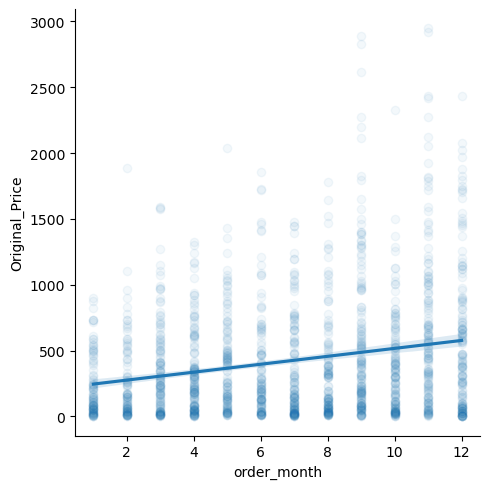

In [39]:
#The purpose of the scatterplot is to visually assess the relationship between the time-related feature 
#'order_month' and the target variable within the training data.
sns.lmplot(x='order_month', y=target, data=train, scatter_kws={'alpha':0.05});

In [40]:
#Here we wrangle the data.
#We used this function to rerun the model training to explore if clipping the dataset 
#had a positive impact of the model accuracy
def wrangle(X):
    X = X.copy()
    X['Original_Price_Clipped'] = X['Original_Price'].clip(lower=0, upper=4000)
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [41]:
# Before we wrange the data
features = ['Region','Category','Sub-Category']
lr(train, val, features, target)

Linear Regression with 3 features: ['Region', 'Category', 'Sub-Category']
Train Root Mean Squared Error: 379.23221304817474
Validation Root Mean Square Error: 337.66294788797296
Train Mean Absolute Error: 265.97314790575916
Validation Mean Absolute Error: 239.87606598984772
Train R^2 Score: 0.3133072548751693
Validation R^2 Score: 0.311124712307807


In [42]:
# After we wrange the data 
features = ['Region','Category','Sub-Category']
lr(train, val, features, target)
#the data wrangling process did not further improve these metrics, 
#suggesting that the initial selection of features already optimized the model's performance to a certain extent.

Linear Regression with 3 features: ['Region', 'Category', 'Sub-Category']
Train Root Mean Squared Error: 379.23221304817474
Validation Root Mean Square Error: 337.66294788797296
Train Mean Absolute Error: 265.97314790575916
Validation Mean Absolute Error: 239.87606598984772
Train R^2 Score: 0.3133072548751693
Validation R^2 Score: 0.311124712307807


In [43]:
#Here we train the model.
from sklearn.feature_selection import f_regression, SelectKBest

# Arrange X, y
features = train.columns.drop([target,'Original_Price'])
X_train = train[features]
X_val = val[features]

# One-hot encode
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# We scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# we used RandomizedSearchCV instead of for loops
ks = range(1, len(X_train_encoded.columns)+1)
maes = []
for k in ks:
    # Select K best features
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_val_selected = selector.transform(X_val_scaled)
    
    # Fit Ridge Regression, use cross-validation to optimize alpha
    model = RidgeCV()
    model.fit(X_train_selected, y_train)
    
    # Get Validation MAE
    y_pred = model.predict(X_val_selected)
    mae = mean_absolute_error(y_val, y_pred)
    maes.append(mae)

    
print('Best K & Validation MAE:')
[(k, mae) for k, mae in zip(ks, maes) if mae==min(maes)]

Best K & Validation MAE:


[(1, 0.02068997306475004)]

In [44]:
# Report test MAE, R^2 for final model

X_train = train[features]
X_test = test[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

selector = SelectKBest(score_func=f_regression, k=26)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_val_scaled)

model = RidgeCV()
model.fit(X_train_encoded, y_train)
y_pred_test = model.predict(X_test_encoded)

print(f'Ridge Regression, final model')
print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
print('Test R^2 Score:', r2_score(y_test, y_pred_test))

Ridge Regression, final model
Test Mean Absolute Error: 0.0007296897175481192
Test R^2 Score: 0.9999999999955044


In [45]:
# Print coefficients for the features
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, X_train_encoded.columns)
print(coefficients.to_string())

Intercept -0.000922182568331209
Quantity                    1.652893e-08
Sub-Category_Accessories   -7.104168e-08
Sub-Category_Appliances     1.596805e-07
Sub-Category_Envelopes     -2.165860e-08
Sub-Category_Machines      -1.129209e-07
Sub-Category_Phones         1.754608e-07
Sub-Category_Art           -1.715436e-07
Sub-Category_Storage        3.250498e-07
Sub-Category_Bookcases      5.370049e-09
Sub-Category_Binders       -1.163958e-07
Sub-Category_Fasteners     -1.092325e-07
Sub-Category_Paper         -1.299843e-07
Sub-Category_Supplies      -3.091742e-08
Sub-Category_Furnishings   -1.959684e-07
Sub-Category_Copiers        1.262271e-07
Sub-Category_Labels        -9.889754e-08
Sub-Category_Chairs         1.872563e-07
Sub-Category_Tables         7.951628e-08
order_month                 6.481562e-09
Region_Central              7.852030e-09
Region_South               -2.184932e-08
Region_East                 1.270250e-09
Region_West                 1.272704e-08
Category_Technology      

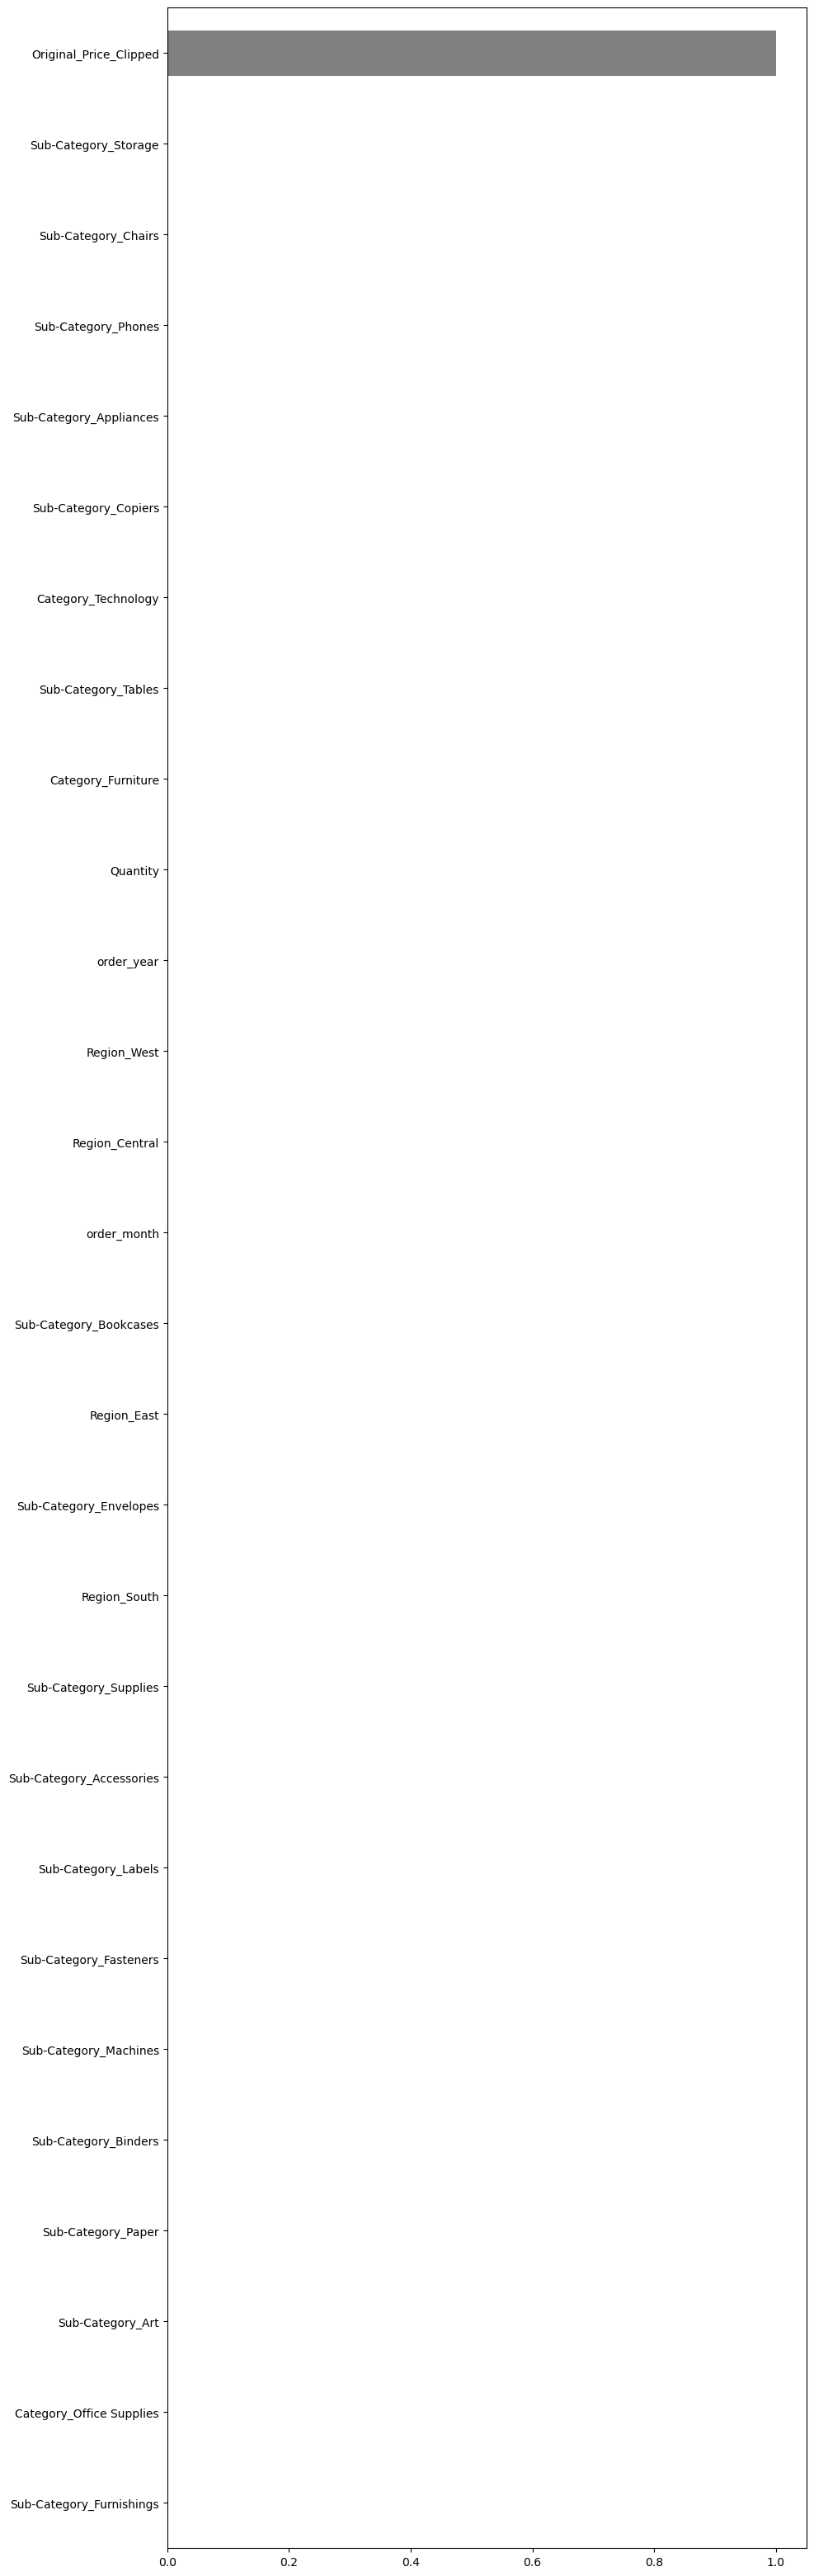

In [46]:
# Plotting the coefficients
%matplotlib inline
coefficients.sort_values().plot.barh(color='grey', figsize=(10,40));

In [47]:
#Here we export and save the model
import joblib
# Save the model
joblib.dump(model, 'model_sales.joblib')

['model_sales.joblib']

In [48]:
#Here we load the saved model
#We added this step to create usable results generated by the model to share with other stakeholders
loaded_model_sales = joblib.load('model_sales.joblib')

In [49]:
#We print X_train encoded to doublecheck the columns we need to run through
X_train_encoded
X_train_encoded.head()

,Quantity,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Envelopes,Sub-Category_Machines,Sub-Category_Phones,Sub-Category_Art,Sub-Category_Storage,Sub-Category_Bookcases,Sub-Category_Binders,...,order_month,Region_Central,Region_South,Region_East,Region_West,Category_Technology,Category_Office Supplies,Category_Furniture,order_year,Original_Price_Clipped
942,11,1,0,0,0,0,0,0,0,0,...,10,1,0,0,0,1,0,0,2021,789.42
365,16,0,1,0,0,0,0,0,0,0,...,9,0,1,0,0,0,1,0,2020,311.32
1234,3,0,0,1,0,0,0,0,0,0,...,4,0,0,1,0,0,1,0,2022,19.35
1345,1,0,0,0,1,0,0,0,0,0,...,6,0,1,0,0,1,0,0,2022,182.95
1037,19,0,0,0,0,1,0,0,0,0,...,11,0,0,0,1,1,0,0,2021,1416.81


In [50]:
#Here we create a list of the features in the model
model_features = X_train_encoded.columns.tolist()

In [51]:
#Here we create the lists that we will run through to populate the dataframe with the predictions
# Get the list of unique categories for 'Category'
category_columns = [col for col in df.columns if 'Region_' in col]
unique_categories = [col.split('_')[-1] for col in category_columns]
print(unique_categories)

# Get the list of unique states for 'State'
state_columns = [col for col in df.columns if 'Category_' in col]
unique_states = [col.split('_')[-1] for col in state_columns]
print(unique_states)
last_known_year = 2023

# Generating future months and years
future_months = np.arange(1, 13)
future_years = np.full(shape=(12,), fill_value=last_known_year + 1)

# Prepare an empty DataFrame to collect all predictions
all_predictions = pd.DataFrame()

#Here we use a loop to generate the predictions with our model

for category in unique_categories:
    for state in unique_states:
        # Creating a DataFrame for future data for each category and state
        future_data = pd.DataFrame({
            'order_month': future_months,
            'order_year': future_years,
            # Add other necessary features or assumed values
        })
        
        # One-hot encode Category and State if they were one-hot encoded during training
        temp_data = pd.concat([future_data, pd.get_dummies(pd.DataFrame({
            'Region': [category] * len(future_data),
            'Category': [state] * len(future_data)
        }))], axis=1)
        print(temp_data)
        # Add any missing columns that were present in the training data
        for feature in model_features:
            if feature not in temp_data.columns:
                temp_data[feature] = 0  # Or use some other method to estimate this feature
        
        # Ensure the order of columns matches the training data
        temp_data = temp_data[model_features]
        
        # Check the structure of future_data
        print(f"Structure for {category}, {state}:")
        print(future_data.head())
        
        # Predicting future sales
        temp_data['Predicted Sales'] = loaded_model_sales.predict(temp_data)
        
        # Store the prediction results
        all_predictions = all_predictions.append(temp_data)

# Display or further process the collected predictions
print(all_predictions)

['Central', 'East', 'South', 'West']
['Furniture', 'Office Supplies', 'Technology', 'Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies', 'Tables']
    order_month  order_year  Region_Central  Category_Furniture
0             1        2024               1                   1
1             2        2024               1                   1
2             3        2024               1                   1
3             4        2024               1                   1
4             5        2024               1                   1
5             6        2024               1                   1
6             7        2024               1                   1
7             8        2024               1                   1
8             9        2024               1                   1
9            10        2024               1                   1
10           11 

C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_prediction

Structure for Central, Machines:
   order_month  order_year
0            1        2024
1            2        2024
2            3        2024
3            4        2024
4            5        2024
    order_month  order_year  Region_Central  Category_Paper
0             1        2024               1               1
1             2        2024               1               1
2             3        2024               1               1
3             4        2024               1               1
4             5        2024               1               1
5             6        2024               1               1
6             7        2024               1               1
7             8        2024               1               1
8             9        2024               1               1
9            10        2024               1               1
10           11        2024               1               1
11           12        2024               1               1
Structure for Central, Pa

C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_prediction

    order_month  order_year  Region_East  Category_Chairs
0             1        2024            1                1
1             2        2024            1                1
2             3        2024            1                1
3             4        2024            1                1
4             5        2024            1                1
5             6        2024            1                1
6             7        2024            1                1
7             8        2024            1                1
8             9        2024            1                1
9            10        2024            1                1
10           11        2024            1                1
11           12        2024            1                1
Structure for East, Chairs:
   order_month  order_year
0            1        2024
1            2        2024
2            3        2024
3            4        2024
4            5        2024
    order_month  order_year  Region_East  Category_Copie

C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_prediction

    order_month  order_year  Region_South  Category_Art
0             1        2024             1             1
1             2        2024             1             1
2             3        2024             1             1
3             4        2024             1             1
4             5        2024             1             1
5             6        2024             1             1
6             7        2024             1             1
7             8        2024             1             1
8             9        2024             1             1
9            10        2024             1             1
10           11        2024             1             1
11           12        2024             1             1
Structure for South, Art:
   order_month  order_year
0            1        2024
1            2        2024
2            3        2024
3            4        2024
4            5        2024
    order_month  order_year  Region_South  Category_Binders
0             1        2

C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_prediction

    order_month  order_year  Region_West  Category_Furniture
0             1        2024            1                   1
1             2        2024            1                   1
2             3        2024            1                   1
3             4        2024            1                   1
4             5        2024            1                   1
5             6        2024            1                   1
6             7        2024            1                   1
7             8        2024            1                   1
8             9        2024            1                   1
9            10        2024            1                   1
10           11        2024            1                   1
11           12        2024            1                   1
Structure for West, Furniture:
   order_month  order_year
0            1        2024
1            2        2024
2            3        2024
3            4        2024
4            5        2024
    order_mont

C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)
C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_prediction

Structure for West, Tables:
   order_month  order_year
0            1        2024
1            2        2024
2            3        2024
3            4        2024
4            5        2024
    Quantity  Sub-Category_Accessories  Sub-Category_Appliances  \
0          0                         0                        0   
1          0                         0                        0   
2          0                         0                        0   
3          0                         0                        0   
4          0                         0                        0   
..       ...                       ...                      ...   
7          0                         0                        0   
8          0                         0                        0   
9          0                         0                        0   
10         0                         0                        0   
11         0                         0                        0   

    S

C:\Users\yoeri\AppData\Local\Temp\ipykernel_19012\1302655907.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_predictions = all_predictions.append(temp_data)


In [52]:
#reforming the dataframe from the encoding output to a normal dataframe
# Initialize new columns with default values (empty strings or NaNs)
all_predictions['Category'] = pd.NA
all_predictions['Region'] = pd.NA

# For each set of one-hot encoded columns, extract the original categorical value
for col in all_predictions.columns:
    if 'Category_' in col:
        all_predictions.loc[all_predictions[col] == 1, 'Sub_Category'] = col.split('Sub-Category_')[-1]
    elif 'Region_' in col:
        all_predictions.loc[all_predictions[col] == 1, 'Region'] = col.split('Region_')[-1]

# List of columns to drop
columns_to_drop = [
    'Region_Central', 'Region_South', 'Region_East', 'Region_West',
    'Category_Technology', 'Category_Office Supplies', 'Category_Furniture'
]

all_predictions = all_predictions.drop(columns=columns_to_drop)

In [53]:
#exporting the predicted sales for 2024 based on our model to a CSV
all_predictions.to_csv('predicted_sales_and_quantity.csv', index=False)